# Howso Life Cycle 

## Scenario

Imagine you manage data storage, maintenance, quality, and distribution at a major credit card provider. Your company's initiative is to harness its enterprise data for AI initiatives. You have been tasked to contribute via: 

1) Providing understanding of whether your data is useful for various AI use cases

2) Ensuring the data is distributed and used securely safely 

Your first use case is to use enterprise data to screen whether customers will default on their payments, so that preventative measures can be taken as soon as possible.

The available data for this use case contains a variety of sensitive information, including the `credit_card_default` output feature, that you will utilize to do your analysis. However, it is challenging to use because it is often mislabeled. This leads to headaches as your team struggles to handle these challenges. 

You turn to Howso to provide insight into your data throughout the lifecycle of this use case. Howso will help you to:

- **Learn** whether your enterprise data is actually useful for this application and understand its qualities

- **Generate** private, usable, and traceable data and inferences that can be harnessed throughout your organization

- **Validate** the data's security and utility, while fixing any issues and providing documentation to verify the data's usability

*Note: Howso encompasses many capabilities, listed in our documentation, which will not be shown for the sake of brevity in this demo. Please ask if you have any questions.*

## Data Prep

In [1]:
from pathlib import Path

from IPython.display import (
    display,
    Image,
    Markdown,
)
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, hex2color
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import plotly.express as px

from howso.engine import Trainee
from howso.synthesizer import Synthesizer
from howso.utilities import infer_feature_attributes
from howso.validator import Validator
from howso.visuals import plot_feature_importances
from howso.watermarker import Watermarker

In [2]:
# Load in data
df = pd.read_csv('financial_data.csv').sample(500)

# Prep Data
df_orig = df.sample(frac=0.8)
df_test = df[~df.index.isin(df_orig.index)].reset_index(drop=True)
df_orig = df_orig.reset_index(drop=True)

# Map Feature Attributes
features = infer_feature_attributes(df_orig)

for f_name in features.get_names(types=("nominal", "ordinal")):
    features[f_name]["non_sensitive"] = True

# features["age"]["type"] = "continuous"
# features["credit_limit_used(%)"]["type"] = "continuous"
# features["no_of_children"]["type"] = "continuous"
# features["total_family_members"]["type"] = "continuous"

action_features = ['credit_card_default']
context_features = features.get_names(without=action_features)

# Create the Trainee
t_orig = Trainee(features=features, name="life_cycle_trainee_orig")

t_orig.train(df_orig)

# Targetless analyze
t_orig.analyze()

cols = df_orig.columns.to_list()

df_orig

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_162273,Goh,31,F,N,Y,0.0,74398.73,365241.0,Unknown,2.0,0.0,25595.16,10137.77,73,532.0,0,1,1
1,CST_132404,Chris,46,F,N,Y,0.0,199912.86,1558.0,Laborers,2.0,0.0,21818.50,22545.62,28,812.0,0,0,0
2,CST_133245,Karen,28,F,N,Y,1.0,74906.22,2363.0,Sales staff,3.0,0.0,NaN,11957.91,35,719.0,0,0,0
3,CST_122834,R,26,F,N,Y,1.0,257895.70,2026.0,Sales staff,3.0,0.0,40421.56,32548.91,28,824.0,0,0,0
4,CST_135145,Yereth,30,F,N,N,0.0,202251.14,1076.0,Laborers,2.0,0.0,9023.52,37902.93,12,715.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,CST_106572,Kylie MacLellan,43,F,Y,Y,0.0,56799.62,1576.0,Managers,2.0,0.0,15499.85,17398.48,49,925.0,0,0,0
396,CST_143462,Junko,41,F,N,N,0.0,90868.31,365251.0,Unknown,2.0,0.0,10980.23,21503.75,6,945.0,0,0,0
397,CST_126609,Tim Kelly,41,M,Y,N,0.0,177922.40,1427.0,Drivers,2.0,1.0,50287.28,67604.78,61,776.0,0,0,0
398,CST_128899,Tetsushi,23,F,Y,Y,0.0,214800.11,654.0,Managers,2.0,0.0,71136.88,32600.86,39,789.0,0,0,0


## Learn

### Understand your data out-of-the-box 

#### Can I use my enterprise data for analytics and predictive intelligence?

We are trying to predict the feature `credit_card_default`. Here, accuracy is used to assess the feature's predictability. If the accuracy is higher that 75%, we will know the data is useful for making these predictions. If the accuracy is below 75%, further action may be required.

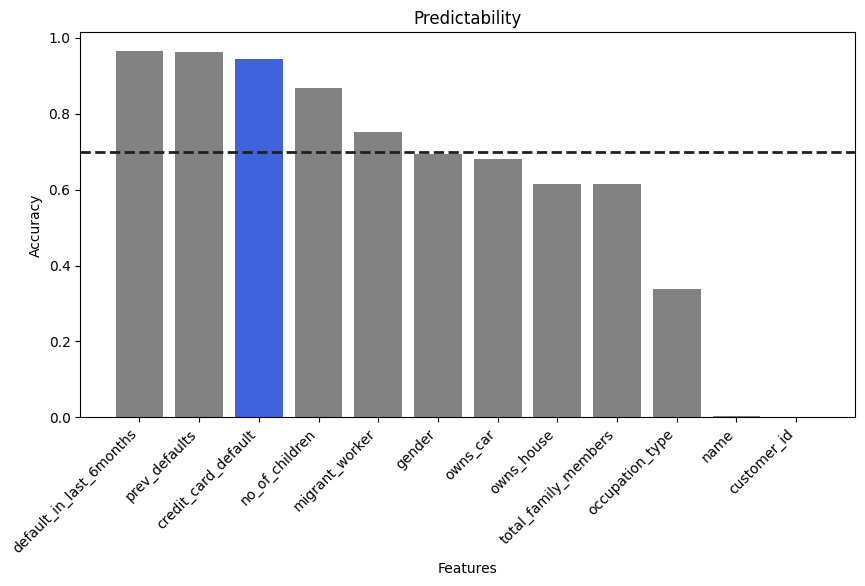

In [3]:
t_orig.react_into_trainee(residuals=True)
stats = t_orig.react_aggregate()

acc_features = stats.loc['accuracy'].dropna()

# Sort the values
sorted_acc = acc_features.sort_values(ascending=False)

# Define the feature to highlight
highlight_feature = 'credit_card_default'
highlight_color = '#3E63DD'  # Color to highlight the specific feature
default_color = '#828282'  # Default color for other features

# Create a list of colors
colors = [highlight_color if feature == highlight_feature else default_color for feature in sorted_acc.index]

# Plot MCC Bar Chart
plt.figure(figsize=(10, 5))
plt.bar(sorted_acc.index, sorted_acc.values, color=colors)
# Add the horizontal line
plt.axhline(y=0.7, color='#202020', linestyle='--', linewidth=2, label=f'Accuracy Threshold = {0.75}')
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.title('Predictability')
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align to the right
plt.show()

### What is driving the predictability?

Next, we identify the features, or columns, that are driving `credit_card_default`'s predictability.

We can see the main contributors to the prediction include information about credit usage and score and previous defaults, this makes sense.

In [4]:
# We reanalyze with `credit_card_default` as the action feature
t_orig.analyze(context_features=context_features, action_features=action_features)

# To get the feature contributions, we `react_into_trainee`. Robust metrics are recommended.
t_orig.react_into_trainee(action_feature= action_features[0], contributions_robust=True)
robust_feature_contributions = t_orig.react_aggregate(action_feature=action_features[0], robust=True, stats=['contribution'])
plot_feature_importances(robust_feature_contributions)

Our initial analysis of our data shows that it is useful for the use case we are proposing (screening for credit defaults), and what is driving this utility. These tools open up many opportunities, including validating any other analytics workflows which use this data. Additionally, these insights can be generated live, as new data is added, and tracked over time so you have a comprehensive view of your data's utility.

Now that we have successfully gained insight into our dataset out of the box, we are ready to move onto the next section of our project. Generating private, usable, and traceable data for utilization within and outside of the organization.

## Generate

### Make your data private, usable, and traceable

You want to share your dataset outside of your organization for testing with external products. You must maintain the data's privacy, utility, and lineage. So, you turn to Howso to synthesize and watermark the data. Then you generate a few predictions of defaults to make sure everything is acceptable and accurate.

#### Synthesize and Watermark

In [5]:
def encode_wm(df,features,wm_string,hyperparameters):
    '''
    Function to run watermarker for a given watermark string.

    Parameters
    ----------
    df : DataFrame
        A DataFrame containing the dataset to watermark
    features : dict
        A dictionary of the dataset's feature attributes
    wm_string : str
        Watermark value
    hyperparameters :
        Synthesis hyperparameters

    Returns
    -------
    wm_attributes : dict
        Dictionary of watermark attributes
    wm_og_df : DataFrame
        A watermarked DataFrame
    '''
    # Initialize Watermarker
    print('Initializing Watermarker')
    watermarker = Watermarker(features=features, reference_df=df_orig, trainee_hyperparameters=hyperparameters)

    # Set up Watermarking configuration
    print('Configuring Watermarker')
    wm_attributes = watermarker.infer_attributes(watermark=wm_string,df=df,base=2.0)#, sorting_features=['customer_id','name','occupation_type','credit_card_default','migrant_worker','total_family_members']) #could auto determine

    # Watermark
    print('Watermarking')
    wm_og_df = watermarker.watermark_string(
        df,
        wm_string,
        wm_attributes,
        generate_new_cases="always",
        desired_conviction=5.0
    )

    return wm_attributes, wm_og_df

def detect_wm(wm_df,wm_attributes,wm_string,decode_method='complete'):
    '''
    Function to run watermarker for a given watermark string.

    Parameters
    ----------
    wm_df : DataFrame
        A watermarked DataFrame
    wm_attributes : dict
        Dictionary of watermark attributes
    wm_string : str
        Watermark value

    Returns
    -------
    score : float
        Detection score of Watermark's presence
    interpretation : str
        Interpretation of the score

    '''
    # Initialize Watermarker
    watermarker = Watermarker(features=features, reference_df=df)

    print('Evaluating Watermarker')
    if decode_method == 'complete':
        score, interpretation, detected_wms = watermarker.evaluate_watermark_presence(wm_df, wm_string, wm_attributes)

    return score, interpretation, detected_wms

In [6]:
# Same size as original dataset
samples = len(df_orig)

# We use the previously created trainee
with Synthesizer(verbose=0) as s:
    s.load_trainee(trainee_name="life_cycle_trainee_orig")
    print('Synthesizing')
    synth_data = s.synthesize_cases(n_samples=samples, generate_new_cases="always")

    hp = s.hyperparams

    # Set up Watermarker specifications
    watermark_string = "Dont Leave Home Without It"
    wm_attributes, wm_df = encode_wm(synth_data,features,watermark_string,hyperparameters=hp)

Synthesizing
Initializing Watermarker
Configuring Watermarker
Watermarking


/Users/bridgettebefort/opt/anaconda3/envs/howso-june24-v2/lib/python3.10/site-packages/howso/watermarker/watermarker.py:268: UserWarning:

There were 75 failed encodings while attempting to preserve privacy. These values remain unchanged.



**Original Data**

In [7]:
# Print out original dataset
df_orig

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_162273,Goh,31,F,N,Y,0.0,74398.73,365241.0,Unknown,2.0,0.0,25595.16,10137.77,73,532.0,0,1,1
1,CST_132404,Chris,46,F,N,Y,0.0,199912.86,1558.0,Laborers,2.0,0.0,21818.50,22545.62,28,812.0,0,0,0
2,CST_133245,Karen,28,F,N,Y,1.0,74906.22,2363.0,Sales staff,3.0,0.0,NaN,11957.91,35,719.0,0,0,0
3,CST_122834,R,26,F,N,Y,1.0,257895.70,2026.0,Sales staff,3.0,0.0,40421.56,32548.91,28,824.0,0,0,0
4,CST_135145,Yereth,30,F,N,N,0.0,202251.14,1076.0,Laborers,2.0,0.0,9023.52,37902.93,12,715.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,CST_106572,Kylie MacLellan,43,F,Y,Y,0.0,56799.62,1576.0,Managers,2.0,0.0,15499.85,17398.48,49,925.0,0,0,0
396,CST_143462,Junko,41,F,N,N,0.0,90868.31,365251.0,Unknown,2.0,0.0,10980.23,21503.75,6,945.0,0,0,0
397,CST_126609,Tim Kelly,41,M,Y,N,0.0,177922.40,1427.0,Drivers,2.0,1.0,50287.28,67604.78,61,776.0,0,0,0
398,CST_128899,Tetsushi,23,F,Y,Y,0.0,214800.11,654.0,Managers,2.0,0.0,71136.88,32600.86,39,789.0,0,0,0


**Synthesized and Watermarked Data**

In [8]:
# Print our watermarked dataset
wm_df[cols]

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
347,CST_100084,John McCrank,40,M,Y,Y,2.0,339566.44,3731.0,Core staff,4.0,0.0,14439.20,44127.90,49,808.0,0,0,0
57,CST_100084,Sarah McBride,25,F,N,Y,1.0,463742.94,70526.0,HR staff,1.0,0.0,57967.86,83167.75,70,836.0,0,0,0
294,CST_100086,ita Bose,43,F,N,N,0.0,70526.93,70526.0,Core staff,2.0,0.0,8815.87,17631.72,31,708.0,0,0,0
303,CST_101406,Huw Jones,63,F,N,Y,2.0,463742.92,70526.0,Low-skill Laborers,4.0,0.0,74351.87,115935.74,23,1007.0,0,0,0
21,CST_101406,Olivia,39,F,N,Y,0.0,86853.21,70526.0,Unknown,2.0,0.0,37947.97,16656.11,46,879.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,CST_165415,Baertlein,31,F,N,Y,0.0,239142.98,114551.0,Security staff,2.0,1.0,23338.05,69117.47,63,915.0,0,0,0
263,CST_165425,Kaori Kaneko,26,F,None,Y,1.0,238118.97,34854.0,Laborers,3.0,0.0,2271.71,36349.48,11,575.0,0,0,0
34,CST_165697,Geller,55,F,N,Y,0.0,108070.98,34854.0,Sales staff,1.0,0.0,18655.71,69117.49,90,831.0,0,0,0
195,CST_165697,Huw,58,M,N,Y,0.0,239142.98,34854.0,Laborers,2.0,1.0,35039.72,3581.49,4,703.0,0,0,0


#### Generate Inferences

**How well does the synthesized and watermarked data predict defaults? Are there any issues?**

First, we look at the overall accuracy of the synthesized and watermarked dataset.

In [9]:
# Infer the feature attributes on the original dataset
wm_features = infer_feature_attributes(wm_df)

# Create the Trainee
t_prod = Trainee(features=wm_features, name="life_cycle_trainee_prod")
t_prod.train(wm_df)
t_prod.analyze(action_features=action_features, context_features=context_features)

t_prod.react_into_trainee(action_feature=action_features[0], residuals=True)
stats = t_prod.react_aggregate()
print(f"Synthetic, watermarked data accuracy: {stats[action_features[0]]['accuracy']:.0%}")
print(f"Recall the feature's accuracy in the original data was : {sorted_acc['credit_card_default']:.0%}")

Synthetic, watermarked data accuracy: 91%
Recall the feature's accuracy in the original data was : 94%


We can see the accuracy remains higher than our predictability threshold of 75%, but it may be a bit lower than original. Let's dig in:

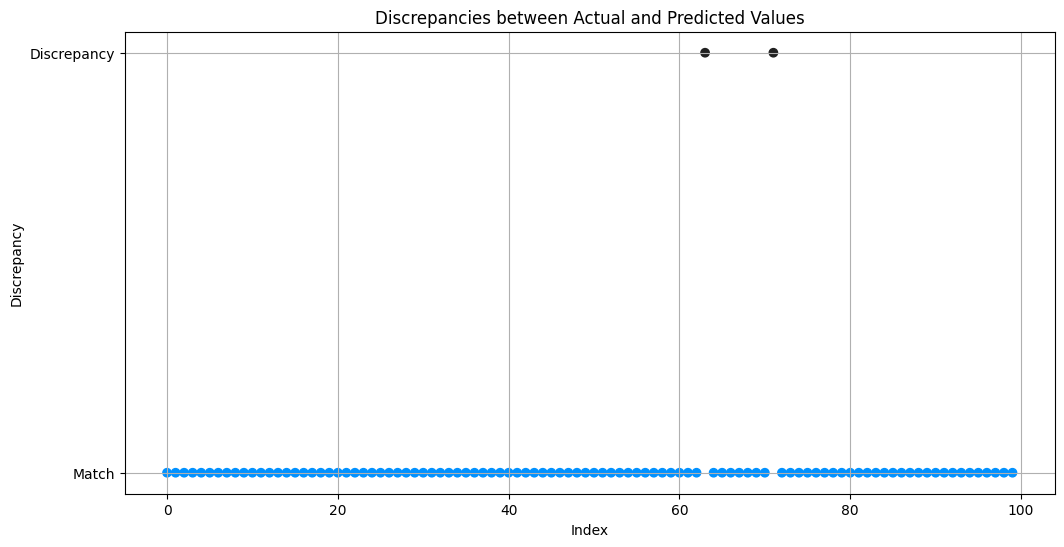

The number of discrepancies between the actual and predicted values is: 2


In [10]:
test_results = t_prod.react(
    df_test[context_features],
    action_features=action_features,
    context_features=context_features)

# Calculate discrepancies
df_test['discrepancy'] = (df_test['credit_card_default'] != test_results['action']['credit_card_default']).astype(int)

# Plot the line plot
plt.figure(figsize=(12, 6))
plt.scatter(df_test.index, df_test['discrepancy'], c=df_test['discrepancy'].map({0: '#0091FF', 1: '#202020'}))  # Scatter plot to highlight points
# plt.scatter(df_test.index, df_test['discrepancy'], marker='o', linestyle='-', color='blue')
plt.xlabel('Index')
plt.ylabel('Discrepancy')
plt.title('Discrepancies between Actual and Predicted Values')
plt.yticks([0, 1], ['Match', 'Discrepancy'])
plt.grid(True)
plt.show()

# Count the discrepancies
discrepancy_count = df_test['discrepancy'].sum()
print(f'The number of discrepancies between the actual and predicted values is: {discrepancy_count}')

#### Edit

**Is my shareable data useful? Can I fix any issues?** 

Let's dig into the first incorrectly predicted case.

In [11]:
prediction_results = test_results['action'].squeeze()

# Grab the index of the first wrongly predicted case
first_incorrect_index = (prediction_results != df_test[action_features[0]]).idxmax()

# The correct results
correct_result = df_test[action_features[0]][first_incorrect_index]

predicted_result = prediction_results.loc[first_incorrect_index]
print(f"Predicted result for case index {first_incorrect_index}:, {predicted_result}. Actual result: {correct_result}.")

Predicted result for case index 63:, 0. Actual result: 1.


What information does this case contain?

In [12]:
# The first predicted incorrect case
examine_case = df_test.iloc[[first_incorrect_index]].reset_index(drop=True)
display(examine_case)

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default,discrepancy
0,CST_154531,Skariachan,39,M,Y,Y,0.0,707085.51,2797.0,Managers,2.0,0.0,60236.36,133260.13,92,513.0,1,0,1,1


Howso provides a variety of capabilities to interpret, understand, and debug your results. 
One of the clearest ways to investigate individual predictions is to visualize the influential cases which contributed to the prediction and which features contributed the most. If we understand this, we can identify any issues in the underlying data. 

First, we will organize the features which contributed the most to the predictions.

In [13]:
investigate_reaction = t_prod.react(
    examine_case[context_features],
    action_features=action_features,
    context_features=context_features,
    details={
        'influential_cases': True,
        'most_similar_cases': True,
        'boundary_cases': True,
        'prediction_stats': True,
        'feature_contributions': True,
        }
)

influential_cases = pd.DataFrame(investigate_reaction['details']['influential_cases'][0])
ms_cases = pd.DataFrame(investigate_reaction['details']['most_similar_cases'][0])
bc_cases = pd.DataFrame(investigate_reaction['details']['boundary_cases'][0])
feature_contributions = pd.DataFrame(investigate_reaction['details']['feature_contributions'])
top_fc_list = feature_contributions.iloc[0].nlargest(3).index.tolist()
top_fc_list.extend(['credit_card_default','.influence_weight'])

cols_ic = ['.influence_weight'] + cols

plot_feature_importances(feature_contributions)

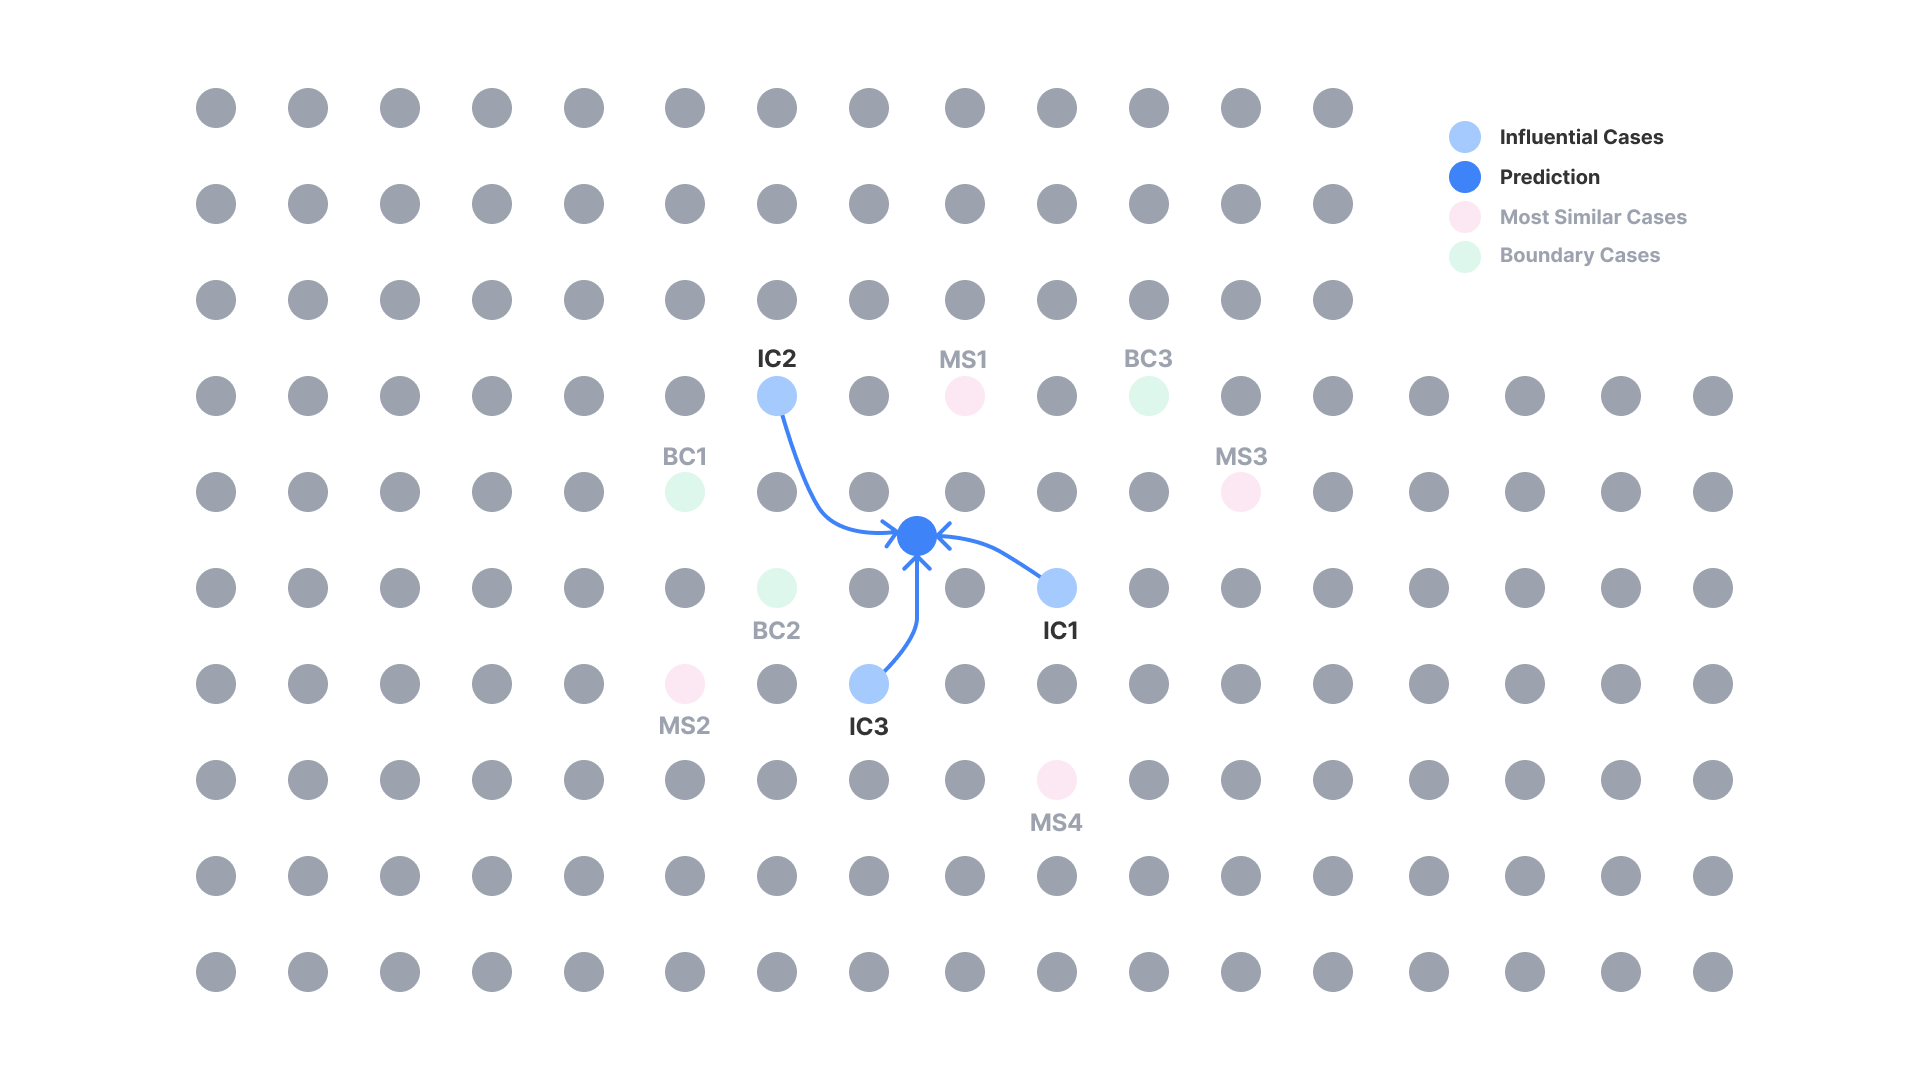

In [14]:
# Display the IC, MS, BC image
Image(filename='../data/InfluentialMostSimilarBoundaryCasesV4.png',width=1000, height=1000)

**Influential Cases**

In [15]:
influential_cases[cols_ic][:5]

,.influence_weight,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,0.407007,CST_119653,Scuffham,38,F,None,Y,0,238089.62,2331,Medicine staff,2,0,29807.93,27816.15,94,528,1,1,1
1,0.309988,CST_152418,Kihara,39,M,Y,N,0,53695.67,36349,Laborers,2,1,1405.24,60821.01,47,670,0,0,0
2,0.283005,CST_149168,Jeffrey Heller,39,M,Y,N,0,709055.68,114542,Managers,2,0,97138.64,28053.02,2,926,0,0,0


**Boundary Cases**

In [16]:
bc_cases[cols_ic][:5]

,.influence_weight,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,0.000000,CST_107107,Katya,39,M,N,N,NaN,70526.92,98012,Managers,5,1,45870.12,14880.61,90,544,2,1,1
1,0.407007,CST_119653,Scuffham,38,F,None,Y,0.0,238089.62,2331,Medicine staff,2,0,29807.93,27816.15,94,528,1,1,1
2,0.000000,CST_130165,Dominic,41,F,Y,N,NaN,174116.41,104207,Unknown,3,0,22287.41,21459.26,87,528,1,1,1


**Most Similar Cases**

In [17]:
ms_cases[cols][:5]

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_119653,Scuffham,38,F,None,Y,0,238089.62,2331,Medicine staff,2,0,29807.93,27816.15,94,528,1,1,1
1,CST_152418,Kihara,39,M,Y,N,0,53695.67,36349,Laborers,2,1,1405.24,60821.01,47,670,0,0,0
2,CST_149168,Jeffrey Heller,39,M,Y,N,0,709055.68,114542,Managers,2,0,97138.64,28053.02,2,926,0,0,0


We can see there are some discrepancies between the features of the predicted case and the data that are influencing the prediction. This may indicate a variety of problems, but for the sake of this demo, we will propose editing the synthetic, watermarked data as a mistake must have been made.

Once we have determined that those cases are incorrectly labeled, we do not need to retrain, or create, a model. We can instead use edit those cases to reflect the correct label. 

In this example, we will edit the 3 most influential cases to have the "correct" label. Again, this is purely for a demonstrative purposes and should not be done just for the sake of accuracy.

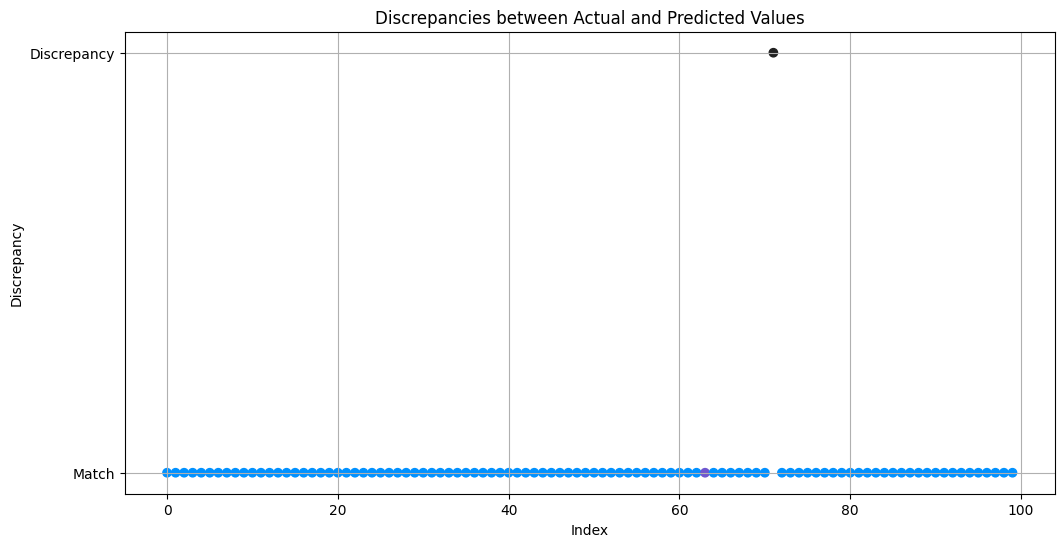

The number of discrepancies between the actual and predicted values is: 1
The predicted post case editing is 1, matching the real result of 1.


In [18]:
# Get the `session_training_index` of the influential cases
influential_cases = pd.DataFrame(investigate_reaction['details']['influential_cases'][0])
influential_cases = influential_cases['.session_training_index'].tolist()
# Get the session id
session_id = t_prod.get_sessions()[0]['id']

# Edit the most influential cases' labels with the "correct" label
for indice in influential_cases:
    t_prod.edit_cases(
        feature_values=[correct_result],
        case_indices=[(session_id, indice)],
        features=action_features
    )

post_edit_result = t_prod.react(
    examine_case[context_features],
    action_features=action_features,
    context_features=context_features
)
post_edit_prediction = post_edit_result['action'][action_features[0]].iloc[0]

# Fixing a discrepancy, for example at index 8
test_results['action'].at[first_incorrect_index, 'credit_card_default'] = post_edit_prediction  # Assuming we fixed this discrepancy by setting predicted to actual

# Calculate discrepancies
df_test['discrepancy'] = (df_test['credit_card_default'] != test_results['action']['credit_card_default']).astype(int)

# Identify the fixed discrepancy
df_test['fixed'] = 0  # Initialize the fixed column with 0
df_test.at[first_incorrect_index, 'fixed'] = 1  # Set the fixed column to 1 for the fixed discrepancy

# Plot the line plot with colored points
plt.figure(figsize=(12, 6))
# plt.plot(df.index, df['discrepancy'], linestyle='-', color='black')  # Line plot

# Scatter plot to highlight points
colors = df_test.apply(lambda row: '#6E56CF' if row['fixed'] == 1 else ('#202020' if row['discrepancy'] == 1 else '#0091FF'), axis=1)
plt.scatter(df_test.index, df_test['discrepancy'], c=colors)

plt.xlabel('Index')
plt.ylabel('Discrepancy')
plt.title('Discrepancies between Actual and Predicted Values')
plt.yticks([0, 1], ['Match', 'Discrepancy'])
plt.grid(True)
plt.show()

# Count the discrepancies
discrepancy_count = df_test['discrepancy'].sum()
print(f'The number of discrepancies between the actual and predicted values is: {discrepancy_count}')

print(f"The predicted post case editing is {post_edit_prediction}, matching the real result of {correct_result}.")

We can see that now when we re-predict the same case, the "correct" result is now predicted and we have resolved another issue in the dataset.

## Validate

### Show your work

We can see there are a few issues. Let's dig in a bit further to validate we are happy with our synthesized and watermarked dataset. Then, we will generate a report of the steps we took throughout this analysis to confirm to ourselve and others that this data is now verifiably usable for our initiatives.

#### Verify

**Can I document my data's privacy, utility, and lineage?**

Finally, you want to report on the privacy and utility of the synthetic, watermarked data, along with any changes/edits you made.

Howso has several tools and metrics that measure the traceability, privacy and utility of the watermarked, synthetic data. We can see that the dataset has good results in all of the different metrics, thus we can proceed to use this data as a stand in for our original data. These results, along with edits, are often printed in a consumable report that can be shared amongst stakeholders and added to a catalog as metadata.

In [19]:
score, interpretation, detected_wms = detect_wm(wm_df,wm_attributes,watermark_string,decode_method='complete')
print(interpretation)
print(detected_wms)

Evaluating Watermarker
Watermark detected.
['Dont Leave Home Without It', 'Dont Leave Home Without It', 'Dont Leave Home Without It', 'Dont Leave Home Without It', 'Dont Leave Home Without It']


In [20]:
with Validator(t_orig, wm_df, features=features, hyperparameters=hp) as val:
    results = val.run_metrics()

Validator Enterprise is enabled. Running without parallelism.
AnonymityPreservation       : Beginning run
AnonymityPreservation       : Run completed with desirability=5.0
DescriptiveStatistics       : Beginning run
DescriptiveStatistics       : Run completed with desirability=3.71
JointProbability            : Beginning run
JointProbability            : Run completed with desirability=4.672
ModelComparison             : Beginning run
ModelComparison             : Run completed with desirability=3.399
SeriesDivergence            : Beginning run
SeriesDivergence            : No time features are detected. Skipping SeriesDivergence.
Run finished with overall_desirability=4.143


In [21]:
for name, result in results.items():
    display(Markdown(f"### {name} - Desirability: {result.desirability}"))
    display(Markdown(result.description))
    # display(result.get_df())

### AnonymityPreservation - Desirability: 5.0

Measure how well the generated data preserve the privacy of the original data by comparing the distance from each generated case to its nearest original neighbor. This distance is divided by the smallest or average distance in that original neighbor's region, acting as a proxy for density called the distance ratio. If this ratio is at least 1, then privacy is maintained. If this ratio is at least 0.5, then plausible deniability is maintained. Desirability is computed on the worst case by default, with a desirability of 5 corresponding to a minimum distance ratio of 1 or greater.

### DescriptiveStatistics - Desirability: 3.71

Shows differences in `basic statistics` between the features of the original and generated data.

### JointProbability - Desirability: 4.672

Measure how well the generated data capture the joint distribution of the original data by estimating the PDF of the data and computing the Jensen-Shanon divergence between both estimates.

### ModelComparison - Desirability: 3.399

Measure how well the generated data can act as a substitute for the original data by comparing model performance. Specifically, trains one model on a training set of the original data and one model on a training set of the generated data and evaluates them both against a test set of the original data. Desirability goes towards 5 as the performance becomes more similar. Degradations in performance of the generated model (e.g., lower accuracy) are punished more harshly than improvements in performance.

While this use case specifically validates the synthesized and watermarked data set, Validation applies to a variety of scenarios, including monitoring your pre-existing models. Below are examples of visuals for these use cases:

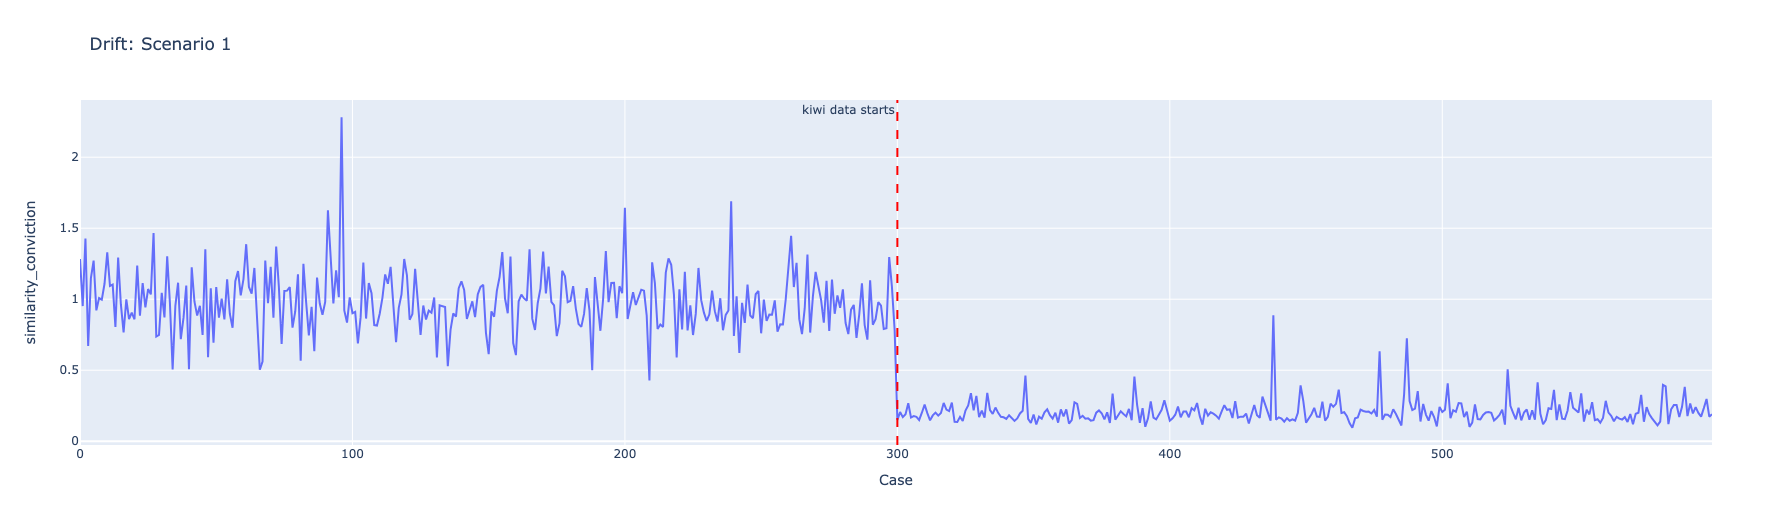

In [22]:
# Display the monitoring image
Image(filename='../data/drift_example.png',width=1000, height=1000)

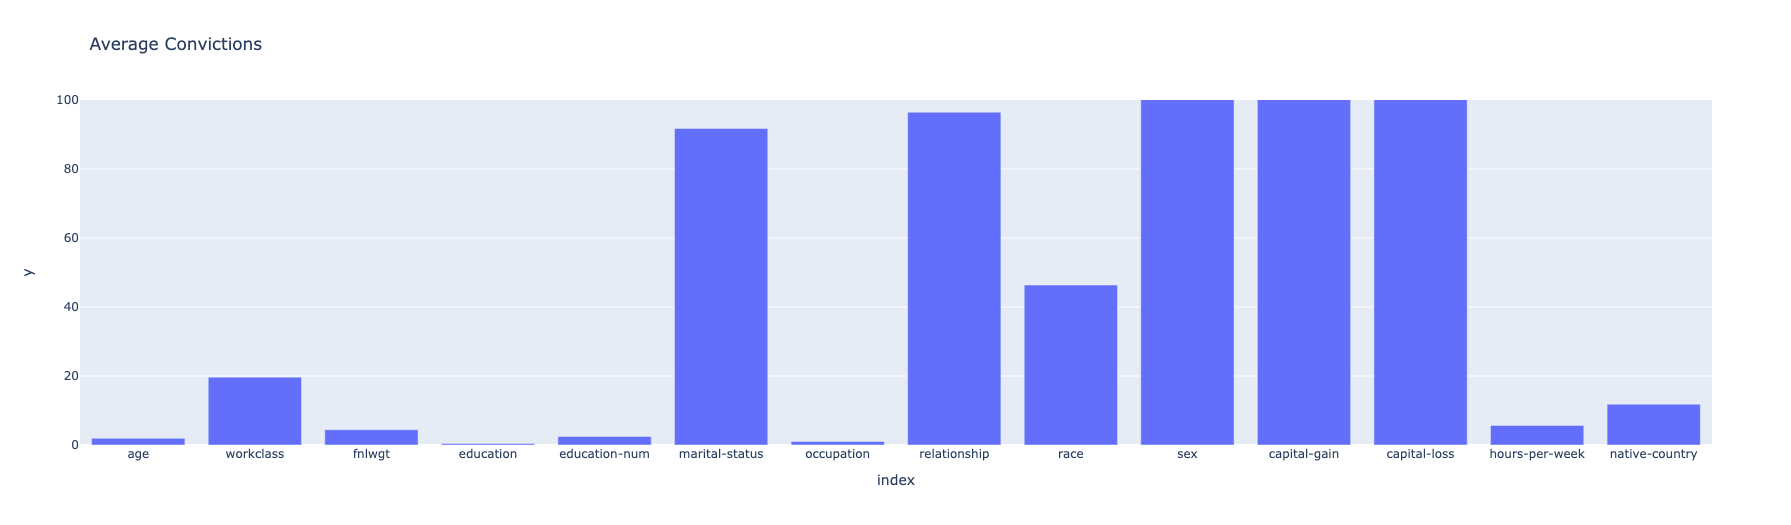

In [23]:
# Display the degbugging image
Image(filename='../data/conviction.png',width=1000, height=1000)

Returning to your project, Howso's ability to track your data throughout its life cycle by providing tools to learn, generate, and validate enabled you to communicate your data's usability for your use case, demonstrate success in the use case, and ensure the data can be verifiably distributed and used securely. This is because Howso works directly with you and your data, not some abstraction.

